/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100, Epsilon: 0.6057704364907278, Avg Reward: -14.069999999999999
Episode 200, Epsilon: 0.3669578217261671, Avg Reward: -929.35
Episode 300, Epsilon: 0.22229219984074702, Avg Reward: -262.7399999999999
Episode 400, Epsilon: 0.1346580429260134, Avg Reward: -730.8299999999995
Episode 500, Epsilon: 0.08157186144027828, Avg Reward: -211.1599999999999
Episode 600, Epsilon: 0.0494138221100385, Avg Reward: -381.6199999999999
Episode 700, Epsilon: 0.029933432588273214, Avg Reward: -1341.7599999999904
Episode 800, Epsilon: 0.018132788524664028, Avg Reward: -11536.48999999952
Episode 900, Epsilon: 0.01098430721937979, Avg Reward: -271756.3999999936
Episode 1000, Epsilon: 0.006653968578831948, Avg Reward: -4.540000000000001


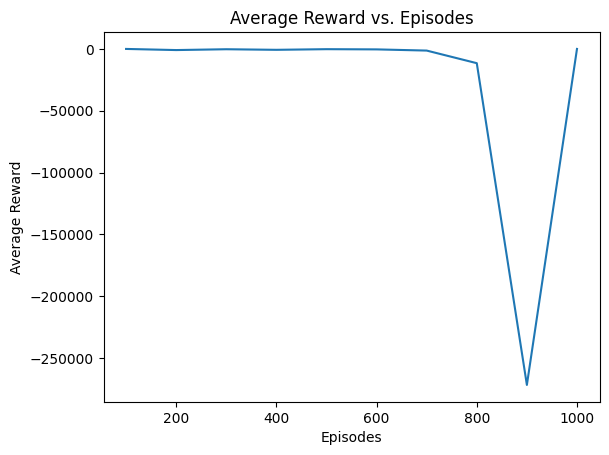

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt

# Utility function for random step generation
def uniform_with_step(start, end, step):
    num_steps = int((end - start) / step)
    random_step = random.randint(0, num_steps)
    result = start + random_step * step
    return result

class GreenhouseEnv:
    def __init__(self, a_tank_capacity, b_tank_capacity, acid_tank_capacity, main_tank_capacity):
        self.a_tank_capacity = a_tank_capacity
        self.b_tank_capacity = b_tank_capacity
        self.acid_tank_capacity = acid_tank_capacity
        self.main_tank_capacity = main_tank_capacity
        self.reset()

    def reset(self):
        self.a_level = uniform_with_step(0.1, 2, 0.1)
        self.b_level = uniform_with_step(0.1, 2, 0.1)
        self.acid_level = uniform_with_step(0.1, 1, 0.05)
        self.pH = uniform_with_step(5.5, 7.5, 0.1)
        self.state = (self.a_level, self.b_level, self.acid_level, self.pH)
        return self.state

    def step(self, action):
        desired_a_mix, desired_b_mix, desired_pH = action

        supply_a = min(0, desired_a_mix - self.a_level)
        supply_b = min(0, desired_b_mix - self.b_level)

        acid_needed = self.calculate_acid_amount(self.pH, desired_pH)
        supply_acid = min(acid_needed, self.acid_level)

        self.a_level += supply_a
        self.b_level += supply_b
        self.acid_level -= supply_acid
        self.pH = desired_pH

        next_state = (self.a_level, self.b_level, self.acid_level, self.pH)

        # Define the reward function
        reward = -abs(self.pH - 6.5)  # For Lettuce, desirable range pH is 6.0-7.0
        if self.a_level < desired_a_mix or self.b_level < desired_b_mix or self.acid_level < acid_needed:
            reward -= 10  # Penalty for not meeting the supply

        done = self.a_level >= desired_a_mix and self.b_level >= desired_b_mix and self.pH <= desired_pH

        self.state = next_state
        return next_state, reward, done, {}

    def calculate_acid_amount(self, current_pH, target_pH):
        if current_pH <= target_pH:
            return 0
        acid_conc = 10**(-4)  # To be Updated
        initial_conc = 10**(-current_pH)
        desired_conc = 10**(-target_pH)

        acid_needed = abs(initial_conc - desired_conc) * self.main_tank_capacity / acid_conc
        return acid_needed

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table = {}

    def get_state_key(self, state):
        return tuple(map(lambda x: round(x, 1), state))

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if random.uniform(0, 1) < self.epsilon or state_key not in self.q_table:
            action = (
                uniform_with_step(0, self.env.a_tank_capacity, 0.05),
                uniform_with_step(0, self.env.b_tank_capacity, 0.05),
                uniform_with_step(5.5, 7.0, 0.1)
            )
        else:
            action = max(self.q_table[state_key], key=self.q_table[state_key].get)
        return action

    def update_q_table(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        action_key = tuple(map(lambda x: round(x, 1), action))

        if state_key not in self.q_table:
            self.q_table[state_key] = {}
        if action_key not in self.q_table[state_key]:
            self.q_table[state_key][action_key] = 0

        max_q_next = max(self.q_table[next_state_key].values()) if next_state_key in self.q_table else 0
        self.q_table[state_key][action_key] = self.q_table[state_key][action_key] + self.lr * (reward + self.gamma * max_q_next - self.q_table[state_key][action_key])

    def train(self, episodes, eval_interval=100):
        avg_rewards = []
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward

            self.epsilon *= self.epsilon_decay

            if (episode + 1) % eval_interval == 0:
                avg_reward = self.evaluate_agent(10)
                avg_rewards.append(avg_reward)
                print(f"Episode {episode + 1}, Epsilon: {self.epsilon}, Avg Reward: {avg_reward}")

        return avg_rewards

    def evaluate_agent(self, num_episodes=10):
        total_rewards = []
        for _ in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = self.choose_action(state)
                state, reward, done, _ = self.env.step(action)
                episode_reward += reward
            total_rewards.append(episode_reward)
        avg_reward = np.mean(total_rewards)
        return avg_reward

    def display_learned_thresholds(self):
        for state_key in sorted(self.q_table.keys()):
            best_action = max(self.q_table[state_key], key=self.q_table[state_key].get)
            print(f"State: {state_key}, Best Action: {best_action}")

# Create the environment
env = GreenhouseEnv(1, 1, 0.5, 10)

# Create the Q-learning agent
agent = QLearningAgent(env)

# Train the agent and get the average rewards
episodes = 1000
eval_interval = 100
avg_rewards = agent.train(episodes, eval_interval)

# Plotting the results
plt.plot(range(eval_interval, episodes + eval_interval, eval_interval), avg_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs. Episodes')
plt.show()
